# Jumps Analysis

## Load Workspace

In [4]:
from matplotlib import pyplot as plt

from scipy import stats as st

import numpy as np

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

import os
os.makedirs('csv-output', exist_ok = True)
os.makedirs('png-output', exist_ok = True)

## Input Filename

In [5]:
filename = 'input'
filename += '.csv'

## Input Dataframe

In [6]:
input_data = pd.read_csv(filename, header = None)
input_data.head()

,0,1
0,127.700,401.000
1,182.600,487.300
2,270.200,417.500
3,269.000,269.900
4,45.900,115.000


## Preparing Canvas

In [7]:
plt.rcParams['figure.figsize'] = 13, 8
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.style'] = 'italic'
plt.style.use('ggplot')

## Visual Analysis

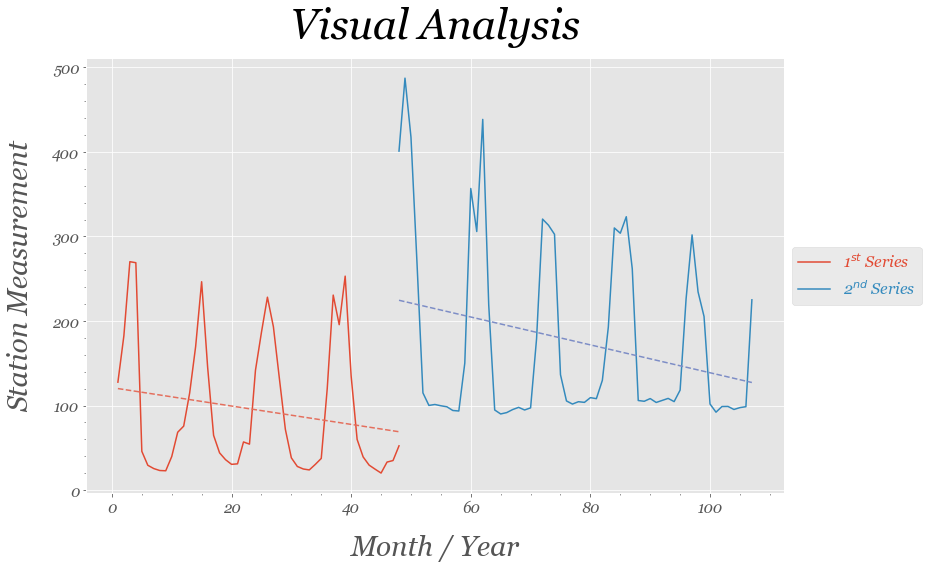

In [8]:
vsy1 = input_data.iloc[:, 0].dropna()
vsy2 = input_data.iloc[:, 1].dropna()

vsx1 = [*range(1, len(vsy1) + 1)]
vsx2 = [*range(len(vsy1), len(vsy1) + len(vsy2))]

tly1 = np.poly1d(np.polyfit(vsx1, vsy1, 1))
tly2 = np.poly1d(np.polyfit(vsx2, vsy2, 1))

ax = plt.axes()
ax.minorticks_on()
ax.set_title('Visual Analysis', fontsize = '42', pad = 20)

plt.ylabel('Station Measurement', fontsize = '28', labelpad = 18)
plt.xlabel('Month / Year', fontsize = '28', labelpad = 18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.plot(vsx1, vsy1, label = '1$^{st}$ Series')
plt.plot(vsx1, tly1(vsx1), linestyle = '--', color = '#E46F5D')

plt.plot(vsx2, vsy2, label = '2$^{nd}$ Series')
plt.plot(vsx2, tly2(vsx2), linestyle = '--', color = '#7D8DC6')

leg = plt.legend(prop = {'size':16}, loc = 'center left', 
                 bbox_to_anchor = (1, 0.5))

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

plt.tight_layout()
plt.savefig('png-output/01_visual_analysis.png', bbox_inches = 'tight')
plt.show()

## Statistic Parameters

In [9]:
params = pd.DataFrame([input_data.count(), input_data.mean(), 
                       input_data.std()])
params.to_csv('csv-output/01_statistic_parameters.csv', header = False, index = False)
params.head()

,0,1
0,48.000,60.000
1,94.600,175.935
2,79.191,107.448


## Parameters Error Bar

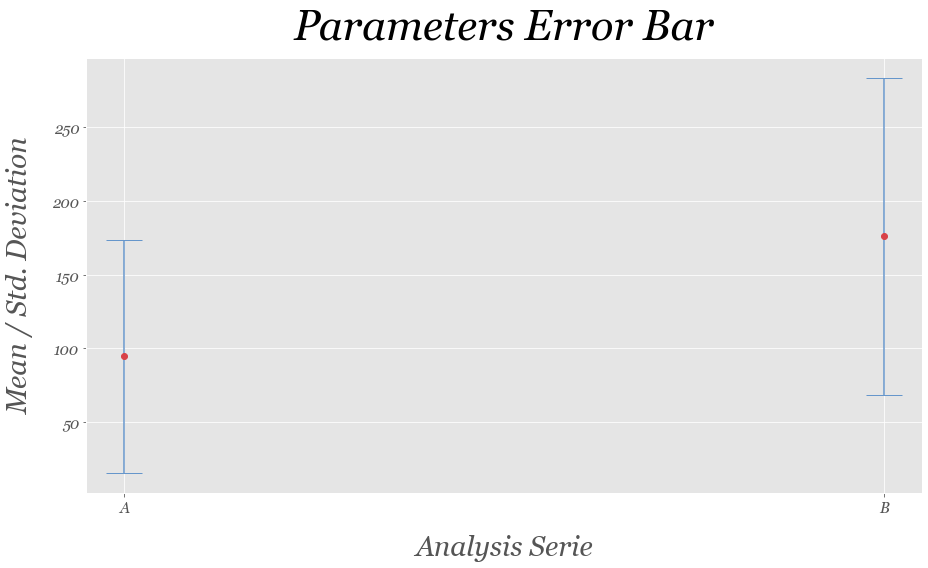

In [10]:
ax = plt.axes()
ax.set_title('Parameters Error Bar', fontsize = '42', pad = 20)

plt.xlabel('Analysis Serie', fontsize = '28', labelpad = 18)
plt.ylabel('Mean / Std. Deviation', fontsize = '28', labelpad = 18)

plt.errorbar(['A', 'B'], params.loc[1], params.loc[2], linestyle = 'None', 
             marker = 'o', color = '#D84147',ecolor = '#6696CB', capsize = 18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.tight_layout()
plt.savefig('png-output/02_parameters_error_bar.png', bbox_inches = 'tight')
plt.show()

## Consistency of the Mean

In [11]:
Sp = ((params.loc[0] - 1) * params.loc[2].pow(2)).sum()
Sp /= params.loc[0].sum() - 2
Sp **= (1 / 2)

Sd = (1 / params.loc[0]).sum() ** (1 / 2)
Sd *= Sp

tc = params.iloc[:, 0] - params.iloc[:, 1]
tc = abs(tc)[1] / Sd

tt = st.t.ppf(.975, params.loc[0].sum() - 2)

cst_mean = pd.DataFrame([[Sp, Sd], [tc, tt]]).transpose()
cst_mean.to_csv('csv-output/02_consistency_mean.csv', header = False, index = False)
cst_mean.head()

,0,1
0,95.951,4.377
1,18.581,1.983


## Consistency of the Std. Deviation

In [12]:
if params.iloc[2, 0] > params.iloc[2, 1]:
    Fc = (params.iloc[2, 0] / params.iloc[2, 1]) ** 2
    Ft = st.f.ppf(0.95, params.iloc[0, 0], params.iloc[0, 1])
else:
    Fc = (params.iloc[2, 1] / params.iloc[2, 0]) ** 2
    Ft = st.f.ppf(0.95, params.iloc[0, 1], params.iloc[0, 0])

cst_stdev = pd.DataFrame([Fc, Ft])
cst_stdev.to_csv('csv-output/03_consistency_std_dev.csv', header = False, index = False)
cst_stdev.head()

,0
0,1.841
1,1.586


## Data Correction

In [13]:
cnss_id = 2 # Consistent Series: 1st or 2nd.

if cnss_id == 1:
    csy2 = (vsy2 - params.iloc[1, 1]) / params.iloc[2, 1]
    csy2 = csy2 * params.iloc[2, 0] + params.iloc[1, 0]
    csy1 = vsy1
else:
    csy1 = (vsy1 - params.iloc[1, 0]) / params.iloc[2, 0]
    csy1 = csy1 * params.iloc[2, 1] + params.iloc[1, 1]
    csy2 = vsy2

output_data = pd.DataFrame([csy1, csy2]).transpose()
output_data.to_csv('csv-output/04_data_correction.csv', header = False, index = False)
output_data.head()

,0,1
0,220.845,401.000
1,295.335,487.300
2,414.192,417.500
3,412.564,269.900
4,109.857,115.000


## Visual Verification

In [14]:
py = csy1.to_list() + csy2.to_list()
px = [*range(1, len(py) + 1)]

tly = np.poly1d(np.polyfit(px, py, 1))

ax = plt.axes()
ax.minorticks_on()
ax.set_title('Visual Verification', fontsize = '42', pad = 20)

plt.ylabel('Corrected Measurement', fontsize = '28', labelpad = 18)
plt.xlabel('Month / Year', fontsize = '28', labelpad = 18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.plot(px, py, color = '#3CCDA7')
plt.plot(px, tly(px), linestyle = '--', color = '#3DDBB1')

plt.tight_layout()
plt.savefig('png-output/03_visual_verification.png', bbox_inches = 'tight')
plt.show()

SyntaxError: invalid syntax (<ipython-input-14-ceb1132f3002>, line 11)